In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import models, optimizers, regularizers
import cv2
import os
import numpy as np

### Primero visualizaremos algunas imágenes

In [2]:
chrys=os.listdir("/kaggle/input/flores/Chrysanthemum/Chrysanthemum")
roses=os.listdir("/kaggle/input/flores/roses/roses")

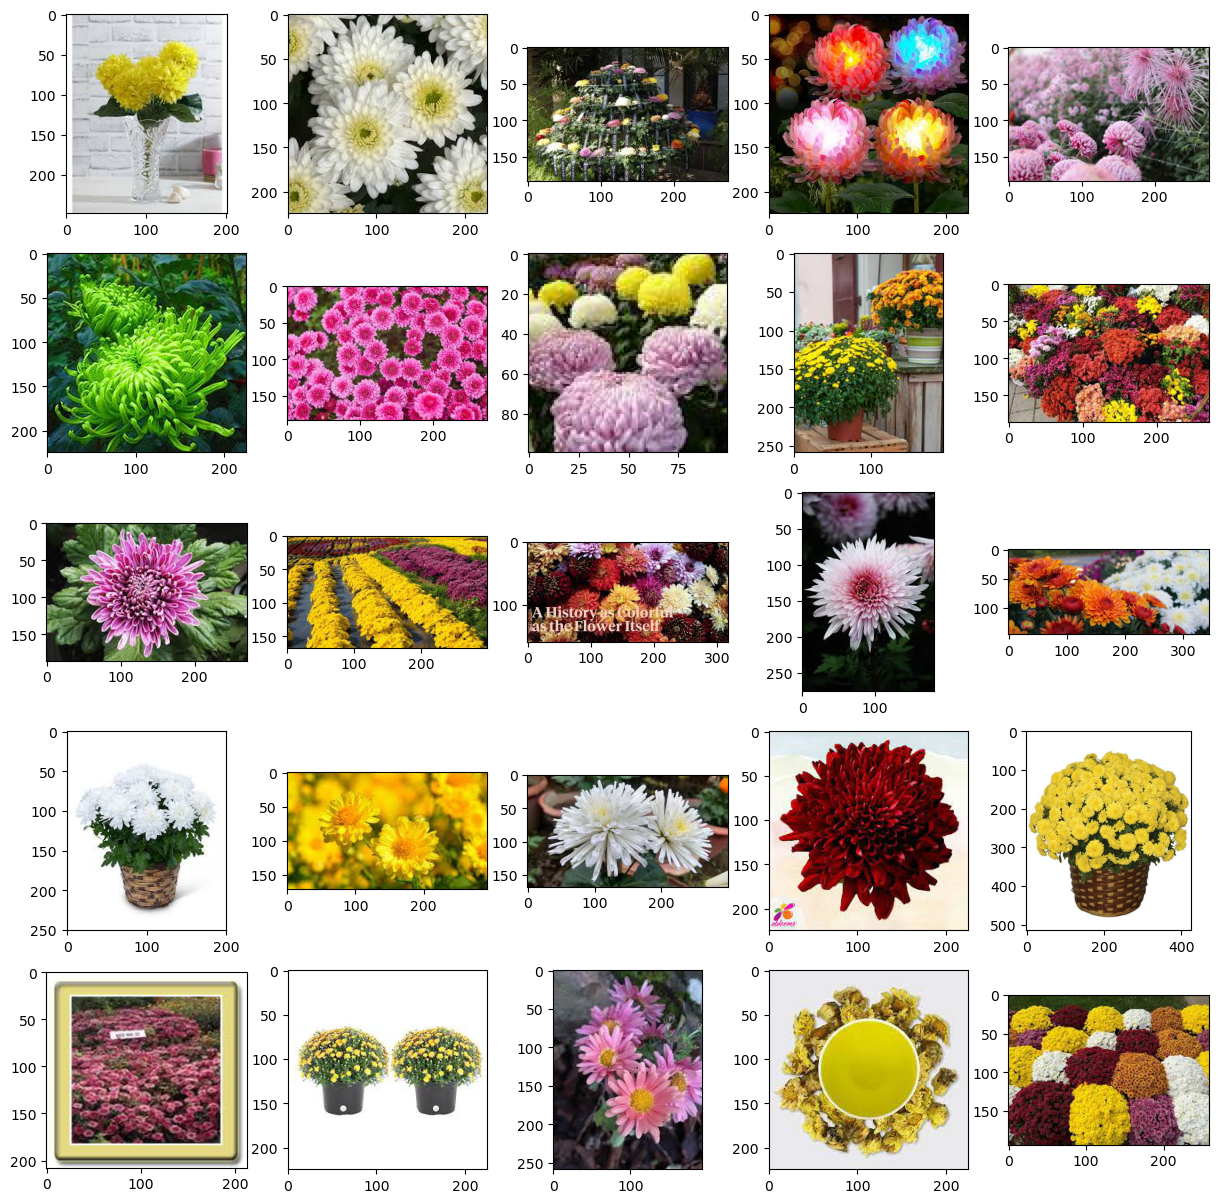

In [3]:
plt.figure(figsize=(15,15))

for i,nombreimg in enumerate(chrys[:25]):
    plt.subplot(5,5,i+1)
    imagen=mpimg.imread("/kaggle/input/flores/Chrysanthemum/Chrysanthemum"+"/"+nombreimg)
    plt.imshow(imagen)

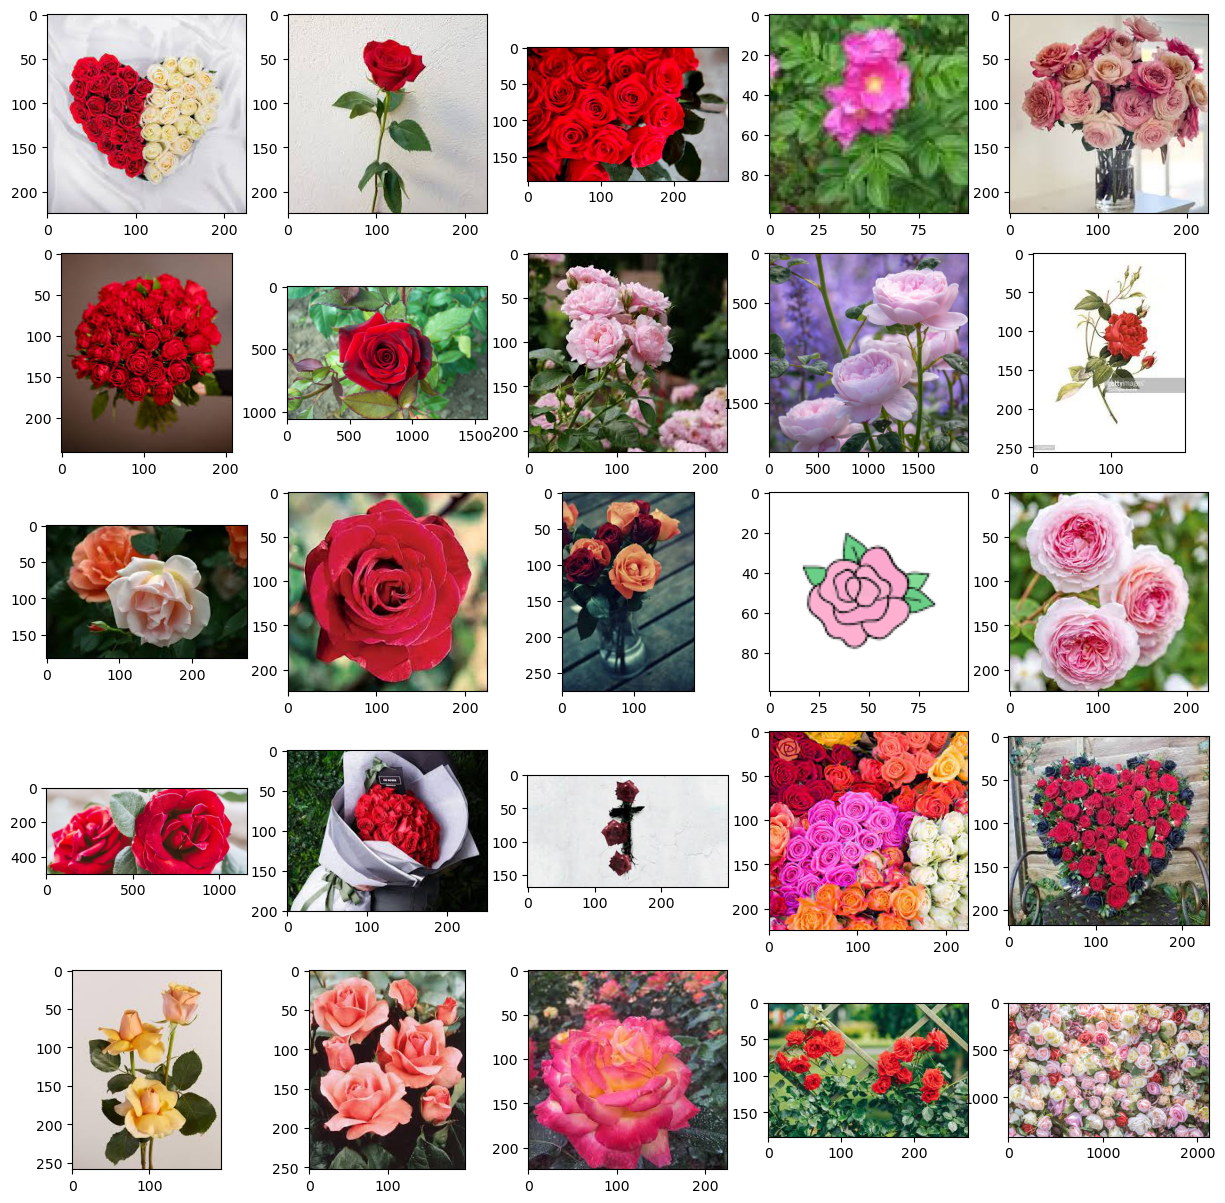

In [4]:
plt.figure(figsize=(15,15))

for i,nombreimg in enumerate(roses[:25]):
    plt.subplot(5,5,i+1)
    imagen=mpimg.imread("/kaggle/input/flores/roses/roses"+"/"+nombreimg)
    plt.imshow(imagen)

## Creamos las carpetas asegurandonos de que tengan el mismo # de imágenes

In [5]:
!mkdir dataset
!mkdir dataset/chrys
!mkdir dataset/roses

In [6]:
import shutil
#Primero haremos con Chrysanthemum
carpeta_fuente="/kaggle/input/flores/Chrysanthemum/Chrysanthemum"
carpeta_destino="/kaggle/working/dataset/chrys"

imagenes= os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
    if i<434:
        #copiar de la carpeta fuente a la destino
        shutil.copy(carpeta_fuente+ "/"+nombreimg,carpeta_destino+"/"+nombreimg)

In [7]:
#Ahora haremos con Roses
carpeta_fuente="/kaggle/input/flores/roses/roses"
carpeta_destino="/kaggle/working/dataset/roses"

imagenes= os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
    if i<434:
        #copiar de la carpeta fuente a la destino
        shutil.copy(carpeta_fuente+ "/"+nombreimg,carpeta_destino+"/"+nombreimg)

## Al tener "Pocas" imágenes, debemos realizar un aumento de datos "Data augmentation"

In [8]:
#creamos el generador
datagen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=15,
    fill_mode="nearest",
    validation_split=0.2,
    zoom_range=0.4
)

## Hay que resaltar que al usar el validation_split , esto me ahorra tener que tener carpetas de Test y de entrenamiento, pero, se requiere al momento de usar el datagen, usar el parámetro "subset", con los nombres "training" y "validation" respectivamente, Keras hace por si solo la división , ahorra mucho trabajo

In [9]:
#Creamos los datos de entrenamiento
data_train = datagen.flow_from_directory("/kaggle/working/dataset",target_size=(224,224),
                                        batch_size=32,
                                        shuffle=True,
                                        #class_mode="binary",
                                        subset="training")

data_validation = datagen.flow_from_directory("/kaggle/working/dataset",target_size=(224,224),
                                        batch_size=32,
                                        shuffle=True,
                                        #class_mode="binary",
                                        subset="validation")

Found 694 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


Imprimiremos algunas imágenes del generador para visualizar esta salida

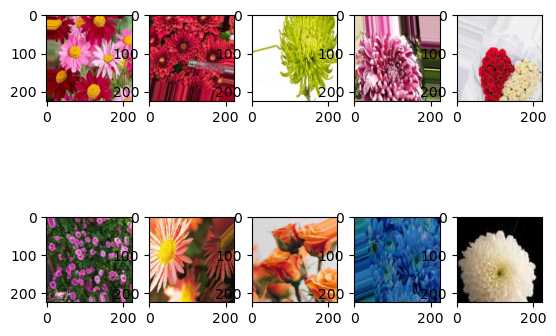

In [10]:
for imagen, etiqueta in data_train:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(imagen[i])
    break
plt.show()

efectivamente vemos que las imágenes tienen transformaciones por el aumento de datos 

## En este caso usaremos un modelo que ya viene entrenado, para probar su eficacia y asi mismo ahorrar tiempo de entrenamiento en nuestro modelo

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

In [12]:
url="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"
imagenet= hub.KerasLayer(url, input_shape=(224,224,3))

In [13]:
#Congelamos el modelo descargado
imagenet.trainable= False

In [14]:
#Creamos la capa de salida de nuestro modelo
model= tf.keras.Sequential([
    imagenet,
    tf.keras.layers.Dense(2,activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 20,333,922
Trainable params: 2,562
Non-trainable params: 20,331,360
_________________________________________________________________


## Ya tenemos el modelo, ahora compilaremos

In [15]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

## Entrenamos el modelo

In [16]:
epocas= 50

hist = model.fit(data_train,
                 epochs=epocas,
                 batch_size=32,
                validation_data=data_validation,)

Epoch 1/50
 2/22 [=>............................] - ETA: 1s - loss: 0.7018 - accuracy: 0.5938  

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


22/22 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.7925

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


22/22 [==============================] - 37s 831ms/step - loss: 0.5532 - accuracy: 0.7925 - val_loss: 0.3995 - val_accuracy: 0.9186
Epoch 2/50
22/22 [==============================] - 15s 690ms/step - loss: 0.3792 - accuracy: 0.8905 - val_loss: 0.2900 - val_accuracy: 0.9360
Epoch 3/50
22/22 [==============================] - 16s 740ms/step - loss: 0.3116 - accuracy: 0.9063 - val_loss: 0.2470 - val_accuracy: 0.9419
Epoch 4/50
22/22 [==============================] - 15s 695ms/step - loss: 0.2710 - accuracy: 0.9150 - val_loss: 0.2079 - val_accuracy: 0.9535
Epoch 5/50
22/22 [==============================] - 16s 727ms/step - loss: 0.2360 - accuracy: 0.9366 - val_loss: 0.1927 - val_accuracy: 0.9477
Epoch 6/50
22/22 [==============================] - 15s 705ms/step - loss: 0.2223 - accuracy: 0.9352 - val_loss: 0.1751 - val_accuracy: 0.9535
Epoch 7/50
22/22 [==============================] - 16s 723ms/step - loss: 0.2024 - accuracy: 0.9323 - val_loss: 0.1579 - val_accuracy: 0.9709
Epoch 8/50

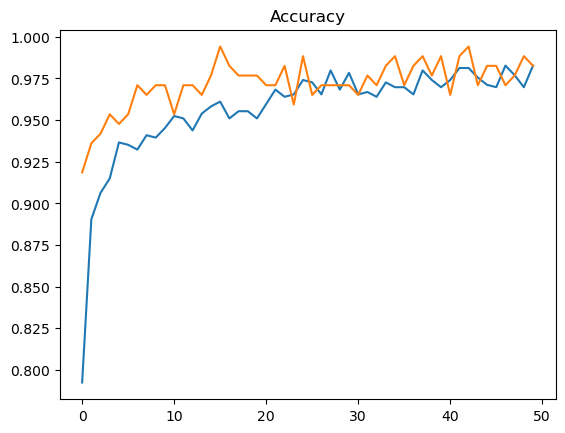

In [17]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Accuracy")
plt.show()

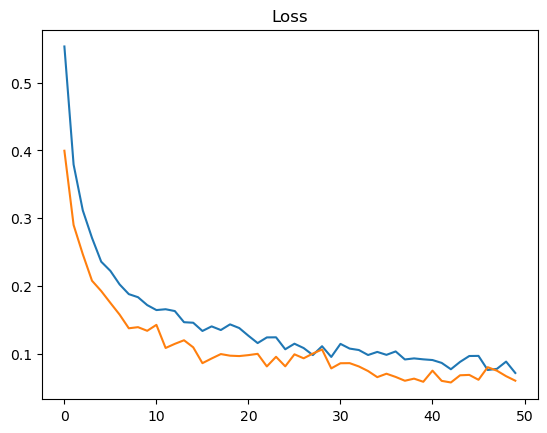

In [18]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss")
plt.show()

## Ahora que entrenamos nuestro modelo, haremos predicciones con este

In [19]:
from PIL import Image
import requests
from io import BytesIO
import cv2

In [20]:
#La función toma un link de una imagen, le modifica su tamaño y posteriormente predice
def clasificar(url):
    respuesta= requests.get(url)
    img= Image.open(BytesIO(respuesta.content))
    img= np.array(img).astype(float)/255
    
    img= cv2.resize(img,(224,224))
    prediccion = model.predict(img.reshape(-1,224,224,3))
    return np.argmax(prediccion[0], axis=-1)

## Ahora probaremos el modelo, en esta caso usando 2 imágenes, si el modelo nos responde con un 0, significa que es un Chrysanthemum, si nos responde con un 1, significa que detecta una rosa

![Usamos esta imagen](https://www.interflora.es/blog/wp-content/uploads/2020/11/crisantemo-scaled.jpg)

In [21]:
#0 = Chrysanthemum
#1 = Roses
url="https://www.interflora.es/blog/wp-content/uploads/2020/11/crisantemo-scaled.jpg"
prediccion= clasificar(url)
print(prediccion)

1/1 [==============================] - 2s 2s/step
0


Usaremos la siguiente imagen:
![](https://cdn.computerhoy.com/sites/navi.axelspringer.es/public/media/image/2020/02/rosa-1857455.jpg?tf=3840x)

In [22]:
#0 = Chrysanthemum
#1 = Roses
url="https://cdn.computerhoy.com/sites/navi.axelspringer.es/public/media/image/2020/02/rosa-1857455.jpg?tf=3840x"
prediccion= clasificar(url)
print(prediccion)

1/1 [==============================] - 0s 36ms/step
1
